### Common code (run this at first)

In [22]:
import time
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

from tools import loader
import config as cfg

dt, dz, dx, dy = 10, 10, 20, 20 # s, m, m, m
harf_smooth_time = 900 # s, <= 300

rho = 1.172414 # kg/m^3, same as PALM
g = 9.81     # m/s^2

flag = 'U0'
time_s = 3600
time_e = 5400

dataset_ts: xr.Dataset = loader.load_base_data(flag=flag, grid_num=1, type='ts')
zi = np.array(np.mean(dataset_ts['zi_wtheta'].loc[np.timedelta64(time_s, 's'): np.timedelta64(time_e, 's')]))
w_star = np.array(np.mean(dataset_ts['w*'].loc[np.timedelta64(time_s, 's'): np.timedelta64(time_e, 's')]))
theta_star = 0.1 / w_star

def partial_t(data):
    return (np.roll(data, shift=-1, axis=0) - np.roll(data, shift=1, axis=0)) / (2 * dt)

def partial_x(data):
    return (np.roll(data, shift=-1, axis=3) - np.roll(data, shift=1, axis=3)) / (2 * dx)

def partial_y(data):
    return (np.roll(data, shift=-1, axis=2) - np.roll(data, shift=1, axis=2)) / (2 * dy)

def partial_z(data):
    if len(data.shape) == 4:
        first_data = (data[:, 1, :, :] - data[:, 0, :, :]) / dz
    else:
        first_data = (data[:, 1] - data[:, 0]) / dz

    result = (np.roll(data, shift=-1, axis=1) - np.roll(data, shift=1, axis=1)) / (2 * dz)

    if len(data.shape) == 4:
        result[:, 0, :, :] = first_data
    else:
        result[:, 0] = first_data
    return result

def get_time_base_data(dataset, time_s, need_data=['w', 'theta', 'p']):
    data = {var: dataset[var] for var in need_data}
    # 筛选需要的时间数据
    time_coords = dataset.coords['time']
    time_nearest = time_coords.sel({"time":np.timedelta64(time_s, 's')}, method='nearest').values # 得到与time, z最接近的索引
    time_index = np.argmax(time_coords.to_numpy() == time_nearest) if np.any(time_coords.to_numpy() == time_nearest) else None

    b_time_index = time_index - int(harf_smooth_time/dt)
    e_time_index = time_index + int(harf_smooth_time/dt + 1)

    result_data = {x:(data[x][b_time_index:e_time_index, :, :, :]) for x in need_data}

    # 坐标统一
    result_data['w'] = (result_data['w'] + np.roll(result_data['w'], shift=-1, axis=1)) / 2

    for key, value in result_data.items():
        if 'zu_3d' in value.coords:
            result_data[key] = value[:, 1:, :, :]

    # 处理数据
    for key, value in result_data.items(): result_data[key] = value[:, :int(1250/dz), :, :]                            # 筛选所需要高度的数据
    z_coords, y_coords = result_data['theta'].coords['zu_3d'].to_numpy(), result_data['theta'].coords['y'].to_numpy()  # 获得坐标
    for key, value in result_data.items(): result_data[key] = value.to_numpy()

    return result_data, z_coords, y_coords

def get_result(input_data, result_flags: list):
    results = {}
    result_shape = (input_data['theta'].shape[0], input_data['theta'].shape[1])
    for flag in result_flags:
        results[flag + '_mean'], results[flag + '_up'], results[flag + '_down'] = np.zeros(result_shape), np.zeros(result_shape), np.zeros(result_shape)

    for i in range(result_shape[0]):
        for j in range(result_shape[1]):
            w_layer = input_data['w'][i, j, :]
            theta_layer = input_data['theta'][i, j, :]
            p_layer = input_data['p'][i, j, :]

            up_mask = w_layer > 0
            down_mask = w_layer < 0

            if "w" in result_flags:
                results['w_mean'][i, j] = np.mean(w_layer)
                results['w_up'][i, j] = np.mean(w_layer[up_mask])
                results['w_down'][i, j] = np.mean(w_layer[down_mask])

            if "theta" in result_flags:
                results['theta_mean'][i, j] = np.mean(theta_layer)
                results['theta_mean'][i, j] = np.mean(theta_layer)
                results['theta_up'][i, j] = np.mean(theta_layer[up_mask])
                results['theta_down'][i, j] = np.mean(theta_layer[down_mask])

            if "p" in result_flags:
                results['p_mean'][i, j] = np.mean(p_layer)
                results['p_up'][i, j] = np.mean(p_layer[up_mask])
                results['p_down'][i, j] = np.mean(p_layer[down_mask])
            
            if "area" in result_flags:
                results['area_up'][i, j] = np.sum(up_mask) * dx * dy
                results['area_down'][i, j] = np.sum(down_mask) * dx * dy

            if "w_2" in result_flags:
                w_2 = np.power(w_layer, 2)
                results['w_2_up'][i, j] = np.mean(w_2[up_mask])
                results['w_2_down'][i, j] = np.mean(w_2[down_mask])
                results['w_2_mean'][i, j] = np.mean(w_2)

    return results

[info] loader load data: ./data/U0_ts.*.nc


/Volumes/储存区/pressure/tools/loader.py:17: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dataset = xr.open_mfdataset(data_path)


### Figure 1. Profiles of updrafts and downdrafts.

[info] loader load data: ./data/U0_3d.*.nc
0 181


/Volumes/储存区/pressure/tools/loader.py:17: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dataset = xr.open_mfdataset(data_path)


(180, 125, 250, 250)


/Volumes/储存区/pressure/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Volumes/储存区/pressure/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


1.4757695
0.06776126
1.172414


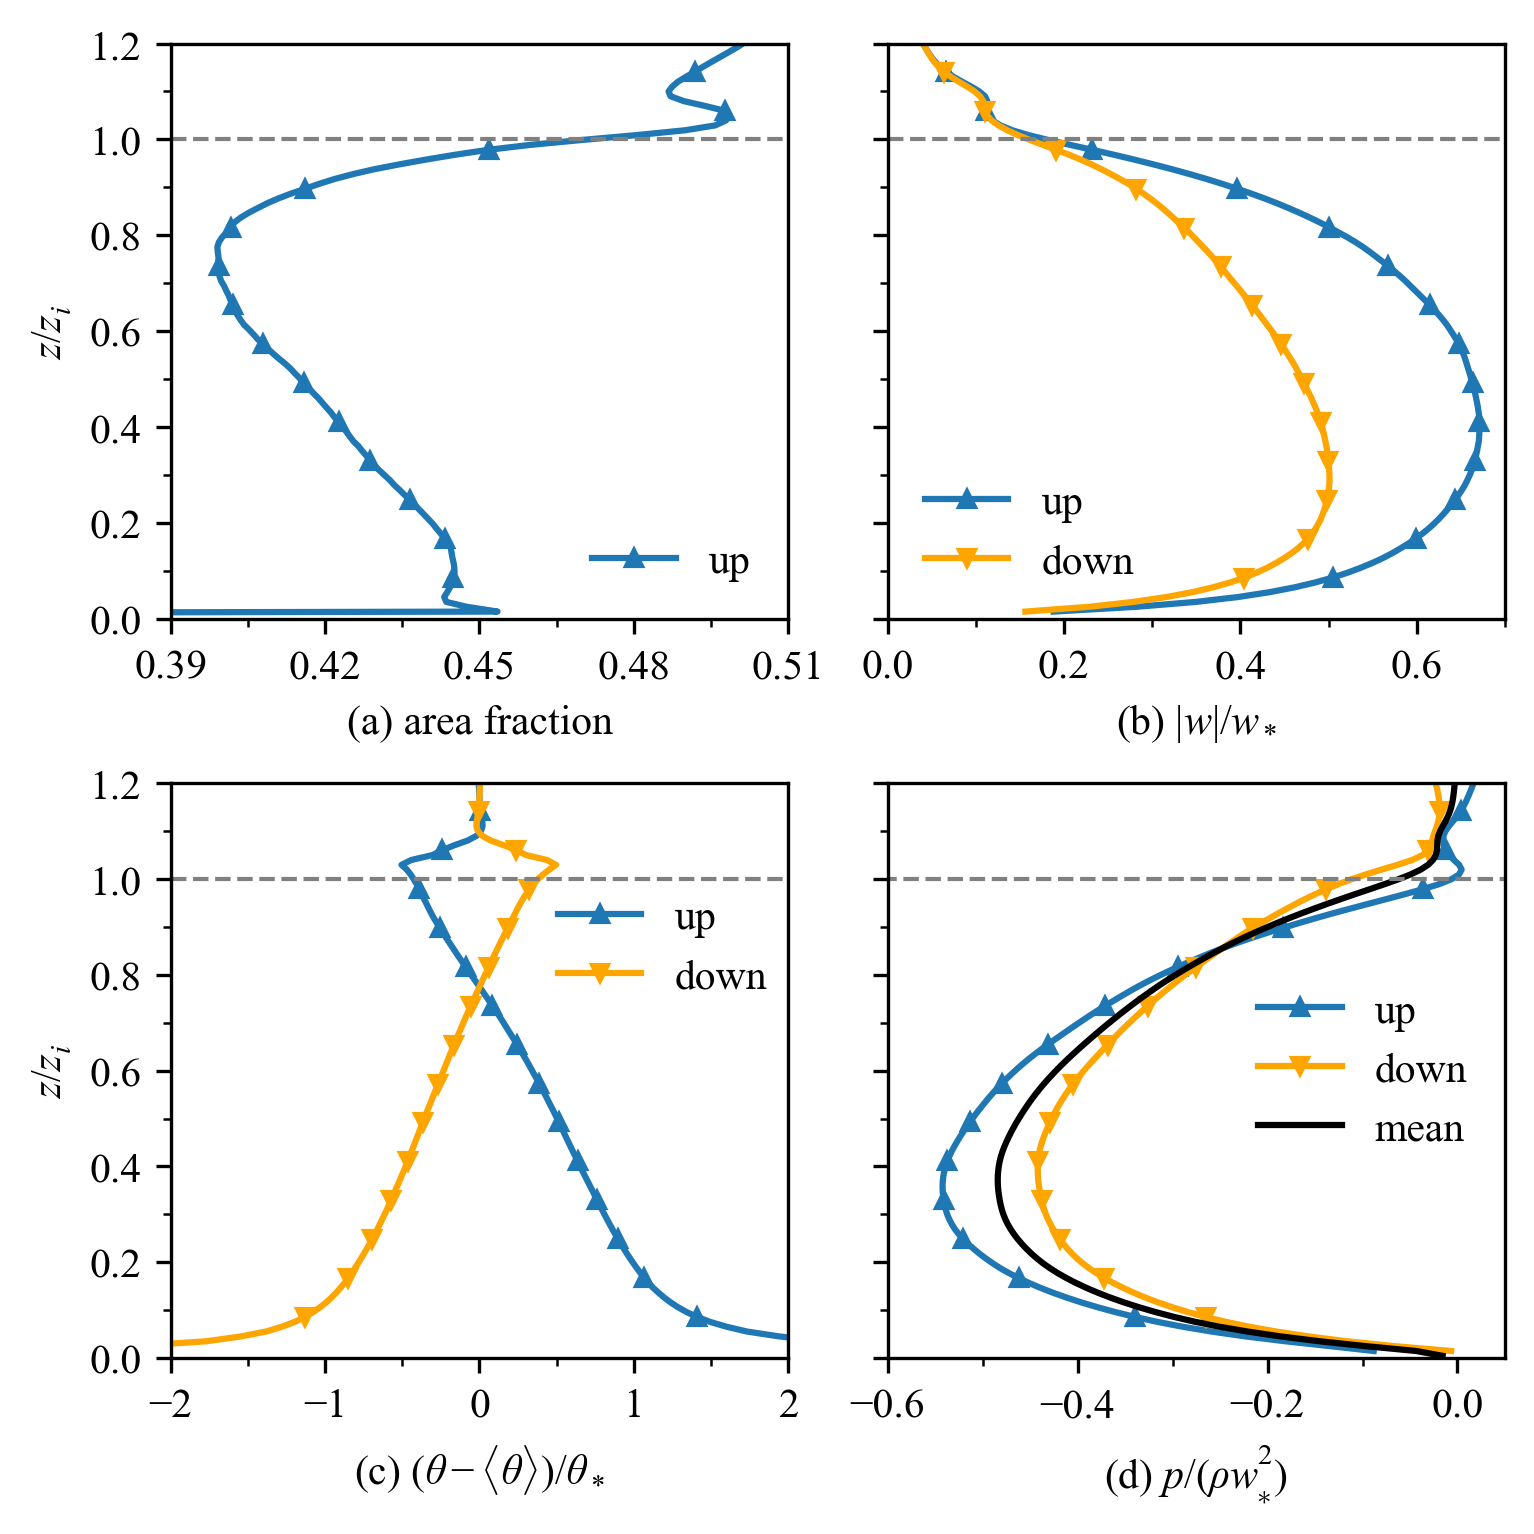

In [18]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(5, 5), dpi=300, constrained_layout=True)

time_s = 4500

# 加载数据
dataset = loader.load_base_data(flag=flag, grid_num=1)
data = {var: dataset[var] for var in ['w', 'theta', 'p']}
(base_data, z_coords, y_coords) = get_time_base_data(dataset, time_s, need_data=['w', 'theta', 'p']) # 获取基础数据
results = get_result(base_data, ['area', 'w', 'theta', 'p'])

## area_up
ax = axes[0][0]
area_up_ratio = np.mean(results['area_up'][1:-1, :]/25000000, axis=0)
ax.plot(area_up_ratio, z_coords/zi, '-^', markersize=4, markevery=8, label=f'up', color=cfg.colors[0])
ax.set_xlim(0.39, 0.51)
ax.set_ylim(0, 1.2)
ax.legend(frameon=False, loc='lower right')
ax.set_xlabel('(a) area fraction')
ax.set_ylabel('$z/z_i$')
ax.hlines(1, 0.39, 0.51, color='grey', ls='dashed', lw=1)
ax.minorticks_on()
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.03))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xticks([0.39, 0.42, 0.45, 0.48, 0.51])

## w
ax = axes[0][1]
w_up = np.mean(results['w_up'][1:-1, :], axis=0) / w_star
w_down = np.mean(results['w_down'][1:-1, :], axis=0) / w_star
w_mean = np.mean(results['w_mean'][1:-1, :], axis=0) / w_star
ax.plot(abs(w_up), z_coords/zi, '-^', label=f'up', markersize=4, markevery=8, color=cfg.colors[0])
ax.plot(abs(w_down), z_coords/zi, '-v', label=f'down', markersize=4, markevery=8, color=cfg.colors[1])
ax.set_ylim(0, 1.2)
ax.set_xlim(0, 0.7)
ax.set_xticks([0.0, 0.2, 0.4, 0.6])
ax.legend(frameon=False)
ax.set_xlabel('(b) $|w|/w_*$')
ax.hlines(1, 0, 0.7, color='grey', ls='dashed', lw=1)
ax.minorticks_on()
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

## theta
ax = axes[1][0]
theta_up = np.mean(results['theta_up'][1:-1, :], axis=0) / theta_star
theta_down = np.mean(results['theta_down'][1:-1, :], axis=0) / theta_star
theta_mean = np.mean(results['theta_mean'][1:-1, :], axis=0) / theta_star
ax.plot(theta_up - theta_mean, z_coords/zi, '-^', label=f'up', markersize=4, markevery=8, color=cfg.colors[0])
ax.plot(theta_down - theta_mean, z_coords/zi, '-v', label=f'down', markersize=4, markevery=8, color=cfg.colors[1])
ax.set_xlim(-2, 2)
ax.set_ylim(0, 1.2)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.legend(frameon=False, loc=[0.6, 0.6])
ax.set_ylabel('$z/z_i$')
ax.set_xlabel('(c) $(\\theta - \\langle \\theta \\rangle) / \\theta_*$')
ax.hlines(1, -2, 2, color='grey', ls='dashed', lw=1)
ax.minorticks_on()
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

## plot p
ax = axes[1][1]
p_up = np.mean( results['p_up'][1:-1, :], axis=0) / (rho * w_star * w_star)
p_down = np.mean( results['p_down'][1:-1, :], axis=0) / (rho * w_star * w_star)
p_mean = np.mean( results['p_mean'][1:-1, :], axis=0) / (rho * w_star * w_star)
ax.plot(p_up, z_coords/zi, '-^', label=f'up', markersize=4, markevery=8, color=cfg.colors[0])
ax.plot(p_down, z_coords/zi, '-v', label=f'down', markersize=4, markevery=8, color=cfg.colors[1])
ax.plot(p_mean, z_coords/zi, label=f'mean', color="black")
ax.set_xlim(-0.6, 0.05)
ax.set_ylim(0, 1.2)
ax.set_xticks([-0.6, -0.4, -0.2, 0.0])
ax.legend(frameon=False)
ax.set_xlabel('(d) $p/(\\rho w^2_{\\ast})$')
ax.hlines(1, -0.7, 0.2, color='grey', ls='dashed', lw=1)
ax.minorticks_on()
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))

# --------------------------------------- plot data ---------------------------------------
plt.show()
plt.close()

### Figure 2. Contributions to the vertical velocity budget for updrafts and downdrafts.

[info] loader load data: ./data/U0_3d.*.nc


/Volumes/储存区/pressure/tools/loader.py:17: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dataset = xr.open_mfdataset(data_path)
/Volumes/储存区/pressure/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Volumes/储存区/pressure/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in divide
  ret = ret.dt

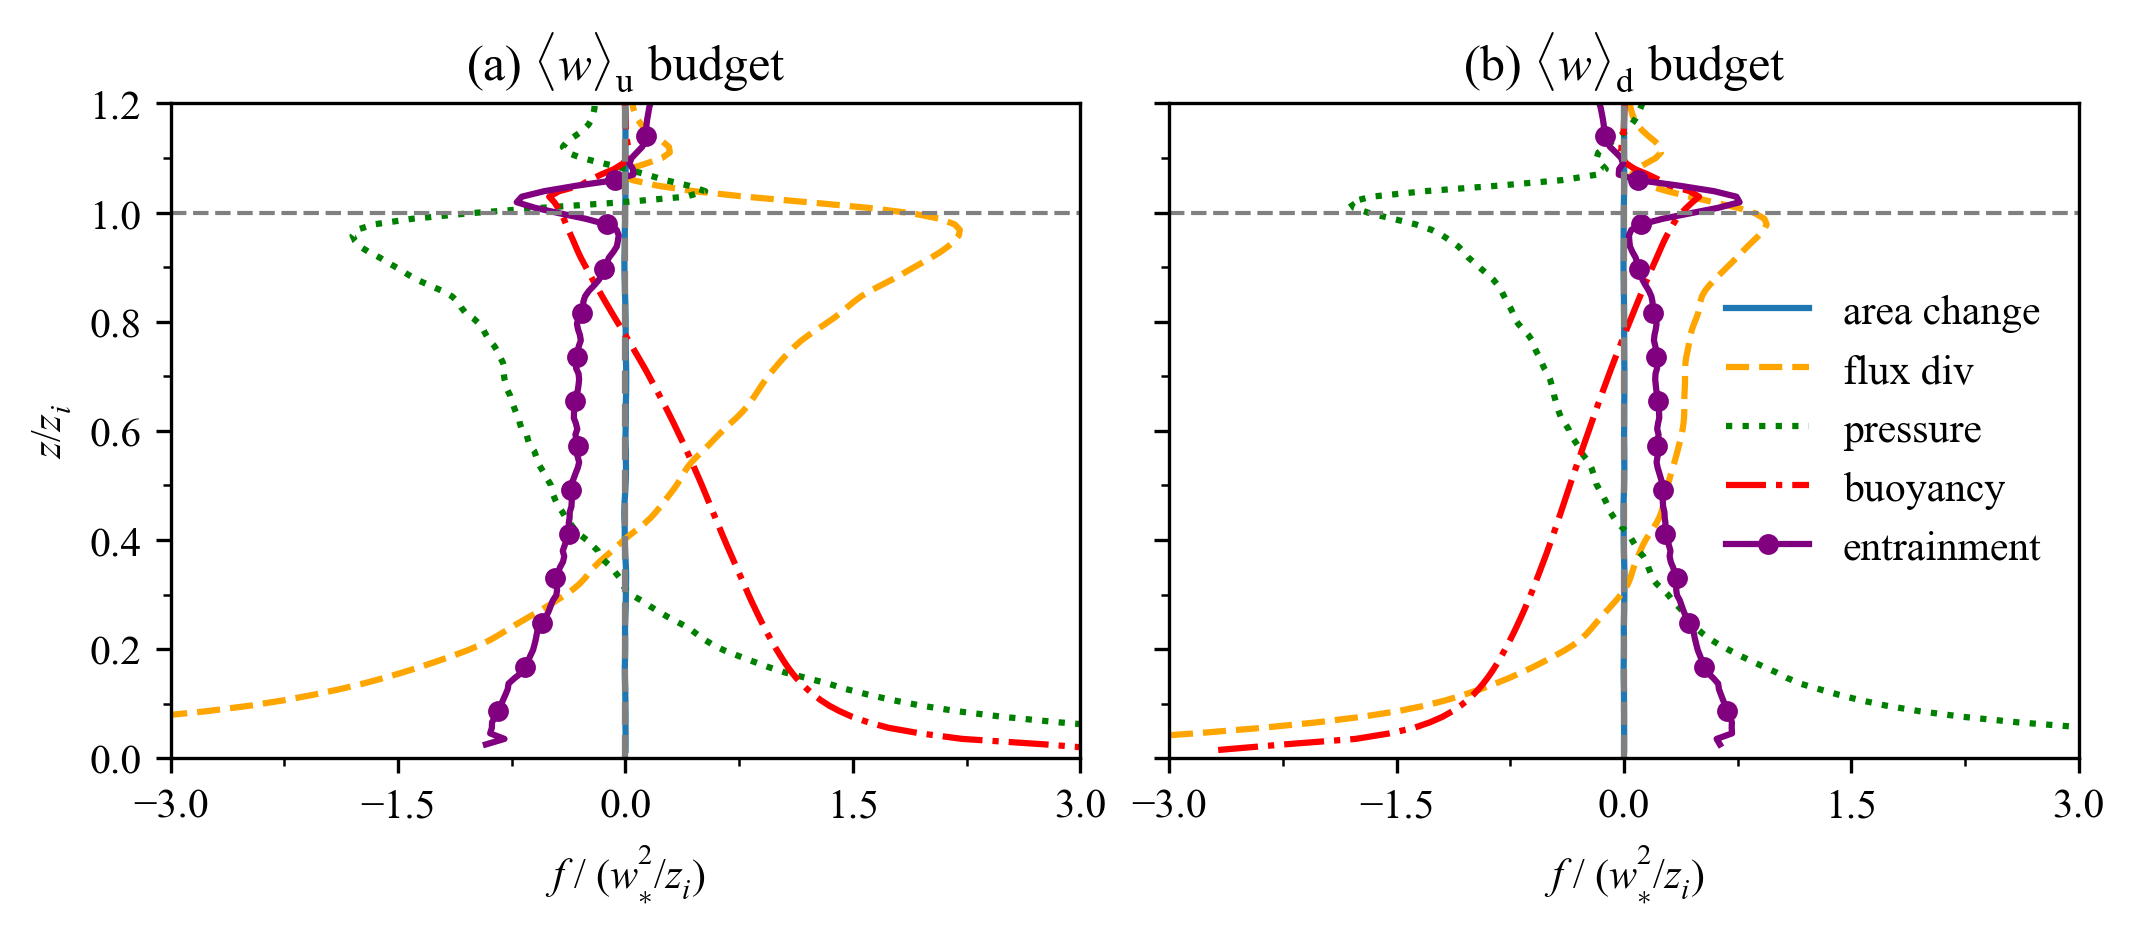

In [23]:
# 加载数据
dataset = loader.load_base_data(flag=flag, grid_num=1)

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(7, 3), dpi=300, constrained_layout=True)
fig_titles = [['(a) $\\langle w\\rangle_\mathrm{u}$ budget', '(b) $\\langle w\\rangle_\mathrm{d}$ budget']]

for i, time_s in enumerate([4500]):
    (base_data, z_coords, y_coords) = get_time_base_data(dataset, time_s) # 获取基础数据

    result_flags = ['w', 'theta', 'p', 'area', 'w_2']
    results = get_result(base_data, result_flags)
    
    # --------------------------------------- w_T budget ---------------------------------------
    w_change_item_thermal = partial_t(results['w_up'])
    area_t_change_item_thermal = - ( results['w_up'] / results['area_up'] * partial_t(results['area_up']) )
    flux_item_thermal = - partial_z(results['w_2_up']) - ( results['w_2_up'] / results['area_up'] * partial_z(results['area_up']) )
    press_item_thermal = - partial_z(results['p_up']) / rho - ( results['p_up'] / results['area_up'] * partial_z(results['area_up']) )
    buoyancy_item_thermal = g / results['theta_mean'] * ( results['theta_up'] - results['theta_mean'] )

    w_change_item_thermal = np.mean(w_change_item_thermal[1:-1, :], axis=0) / (w_star * w_star / zi)
    area_t_change_item_thermal = np.mean(area_t_change_item_thermal[1:-1, :], axis=0) / (w_star * w_star / zi)
    flux_item_thermal = np.mean(flux_item_thermal[1:-1, :], axis=0) / (w_star * w_star / zi)
    press_item_thermal = np.mean(press_item_thermal[1:-1, :], axis=0) / (w_star * w_star / zi)
    buoyancy_item_thermal = np.mean(buoyancy_item_thermal[1:-1, :], axis=0) / (w_star * w_star / zi)
    res_thermal = w_change_item_thermal - ( area_t_change_item_thermal + flux_item_thermal + press_item_thermal + buoyancy_item_thermal )

    ax = axes[0]
    ax.plot(area_t_change_item_thermal, z_coords/zi, cfg.line_styles[0], label='area change', color=cfg.colors[0], markersize=4, markevery=8)
    ax.plot(flux_item_thermal, z_coords/zi, cfg.line_styles[1], label='flux div', color=cfg.colors[1], markersize=4, markevery=8)
    ax.plot(press_item_thermal, z_coords/zi, cfg.line_styles[2], label='pressure', color=cfg.colors[2], markersize=4, markevery=8)
    ax.plot(buoyancy_item_thermal, z_coords/zi, cfg.line_styles[3], label='buoyancy', color=cfg.colors[3], markersize=4, markevery=8)
    ax.plot(res_thermal, z_coords/zi, cfg.line_styles[4], label='entrainment', color=cfg.colors[4], markersize=4, markevery=8)
    
    ax.set_xlim([-3, 3])
    ax.set_xticks([-3, -1.5, 0, 1.5, 3])
    ax.set_xlabel('$f\ /\ (w_{\\ast}^2 / z_i )$')
    ax.vlines(0, 0, 1.2, colors='grey', linestyles='--')
    ax.set_ylim([0, 1.2])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
    ax.set_ylabel('$z/z_i$')
    ax.set_title(fig_titles[i][0])

    ax.hlines(1, -3, 3, color='grey', ls='dashed', lw=1)

    ax.minorticks_on()
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_major_locator(plt.MultipleLocator(1.5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))

    # --------------------------------------- w_E budget ---------------------------------------
    w_change_item_env = partial_t(results['w_down'])
    area_t_change_item_env = - ( results['w_down'] / results['area_down'] * partial_t(results['area_down']) )
    flux_item_env = -partial_z(results['w_2_down']) - ( results['w_2_down'] / results['area_down'] * partial_z(results['area_down']) )
    press_item_env = -partial_z(results['p_down']) / rho - ( results['p_down'] / results['area_down'] * partial_z(results['area_down']) )
    buoyancy_item_env = g / results['theta_mean'] * (results['theta_down'] - results['theta_mean'])

    w_change_item_env = np.mean(w_change_item_env[1:-1, :], axis=0)  / (w_star * w_star / zi)
    area_t_change_item_env = np.mean(area_t_change_item_env[1:-1, :], axis=0)  / (w_star * w_star / zi)
    flux_item_env = np.mean(flux_item_env[1:-1, :], axis=0)  / (w_star * w_star / zi)
    press_item_env = np.mean(press_item_env[1:-1, :], axis=0)  / (w_star * w_star / zi)
    buoyancy_item_env = np.mean(buoyancy_item_env[1:-1, :], axis=0)  / (w_star * w_star / zi)
    res_env = w_change_item_env -( area_t_change_item_env + flux_item_env + press_item_env + buoyancy_item_env)

    ax = axes[1]
    ax.plot(area_t_change_item_env, z_coords/zi, cfg.line_styles[0], label='area change', color=cfg.colors[0], markersize=4, markevery=8)
    ax.plot(flux_item_env, z_coords/zi, cfg.line_styles[1], label='flux div', color=cfg.colors[1], markersize=4, markevery=8)
    ax.plot(press_item_env, z_coords/zi, cfg.line_styles[2], label='pressure', color=cfg.colors[2], markersize=4, markevery=8)
    ax.plot(buoyancy_item_env, z_coords/zi, cfg.line_styles[3], label='buoyancy', color=cfg.colors[3], markersize=4, markevery=8)
    ax.plot(res_env, z_coords/zi, cfg.line_styles[4], label='entrainment', color=cfg.colors[4], markersize=4, markevery=8)

    ax.set_xlim([-3, 3])
    ax.set_xticks([-3, -1.5, 0, 1.5, 3])
    ax.set_xlabel('$f\ /\ (w_{\\ast}^2 / z_i )$')
    ax.vlines(0, 0, 1.2, colors='grey', linestyles='--')
    ax.set_title(fig_titles[i][1])

    ax.hlines(1, -3, 3, color='grey', ls='dashed', lw=1)

    ax.xaxis.set_major_locator(plt.MultipleLocator(1.5))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))

    ax.legend(frameon=False)
plt.show()
plt.close()

### Figure 3. Profiles of resolvable pressure and its contributions.

In [27]:
# 加载数据
solve_p_data = xr.open_dataset(f"./data/{flag}_press_solve.nc")
source_data = xr.open_dataset(f"./data/{flag}_press_source.nc")
z_coords = source_data.coords['z'][1:]
w = source_data['w'][:, 1:, :, :]
p = source_data['p'][:, 1:, :, :]

# 要处理的压力分量
fields_all = ['p_inertial', 'p_buoyancy', 'p', 'res']
fields_direct = ['p_inertial', 'p_buoyancy']
mean_up, mean_down = {}, {}
std_up, std_down = {}, {}
std = {}

# 计算各分量上下均值/方差
for f in fields_all:
    mean_up[f] = np.zeros((w.shape[0], w.shape[1]))
    mean_down[f] = np.zeros((w.shape[0], w.shape[1]))
    std_up[f] = np.zeros((w.shape[0], w.shape[1]))
    std_down[f] = np.zeros((w.shape[0], w.shape[1]))
    std[f] = np.zeros((w.shape[0], w.shape[1]))

for z in range(w.shape[1]):
    for t in range(0, w.shape[0]):
        w_layer = w[t, z].to_numpy()
        up = w_layer > 0
        down = w_layer < 0

        vals = {f: solve_p_data[f][t, z].to_numpy() for f in fields_direct}
        vals['p'] = p[t, z].to_numpy()
        vals['res'] = vals['p'] - vals['p_inertial'] - vals['p_buoyancy']

        for f in vals:
            this = vals[f]
            mean_up[f][t, z] = this[up].mean()
            mean_down[f][t, z] = this[down].mean()
            std_up[f][t, z] = this[up].std()
            std_down[f][t, z] = this[down].std()
            std[f][t,z] = this.std()

# 沿时间均值
mean_up = {k: v.mean(axis=0) / (rho * w_star * w_star) for k, v in mean_up.items()}
mean_down = {k: v.mean(axis=0) / (rho * w_star * w_star) for k, v in mean_down.items()}
std_up = {k: v.mean(axis=0) / (rho * w_star * w_star) for k, v in std_up.items()}
std_down = {k: v.mean(axis=0) / (rho * w_star * w_star) for k, v in std_down.items()}
std = {k: v.mean(axis=0) / (rho * w_star * w_star) for k, v in std.items()}

/var/folders/s2/5pcw9vy556140_w0pbyxr2nw0000gn/T/ipykernel_13467/2995839028.py:35: RuntimeWarning: Mean of empty slice.
  mean_up[f][t, z] = this[up].mean()
/Volumes/储存区/pressure/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/s2/5pcw9vy556140_w0pbyxr2nw0000gn/T/ipykernel_13467/2995839028.py:36: RuntimeWarning: Mean of empty slice.
  mean_down[f][t, z] = this[down].mean()
/Volumes/储存区/pressure/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Volumes/储存区/pressure/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Volumes/储存区/pressure/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid va

/var/folders/s2/5pcw9vy556140_w0pbyxr2nw0000gn/T/ipykernel_13467/1213711457.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


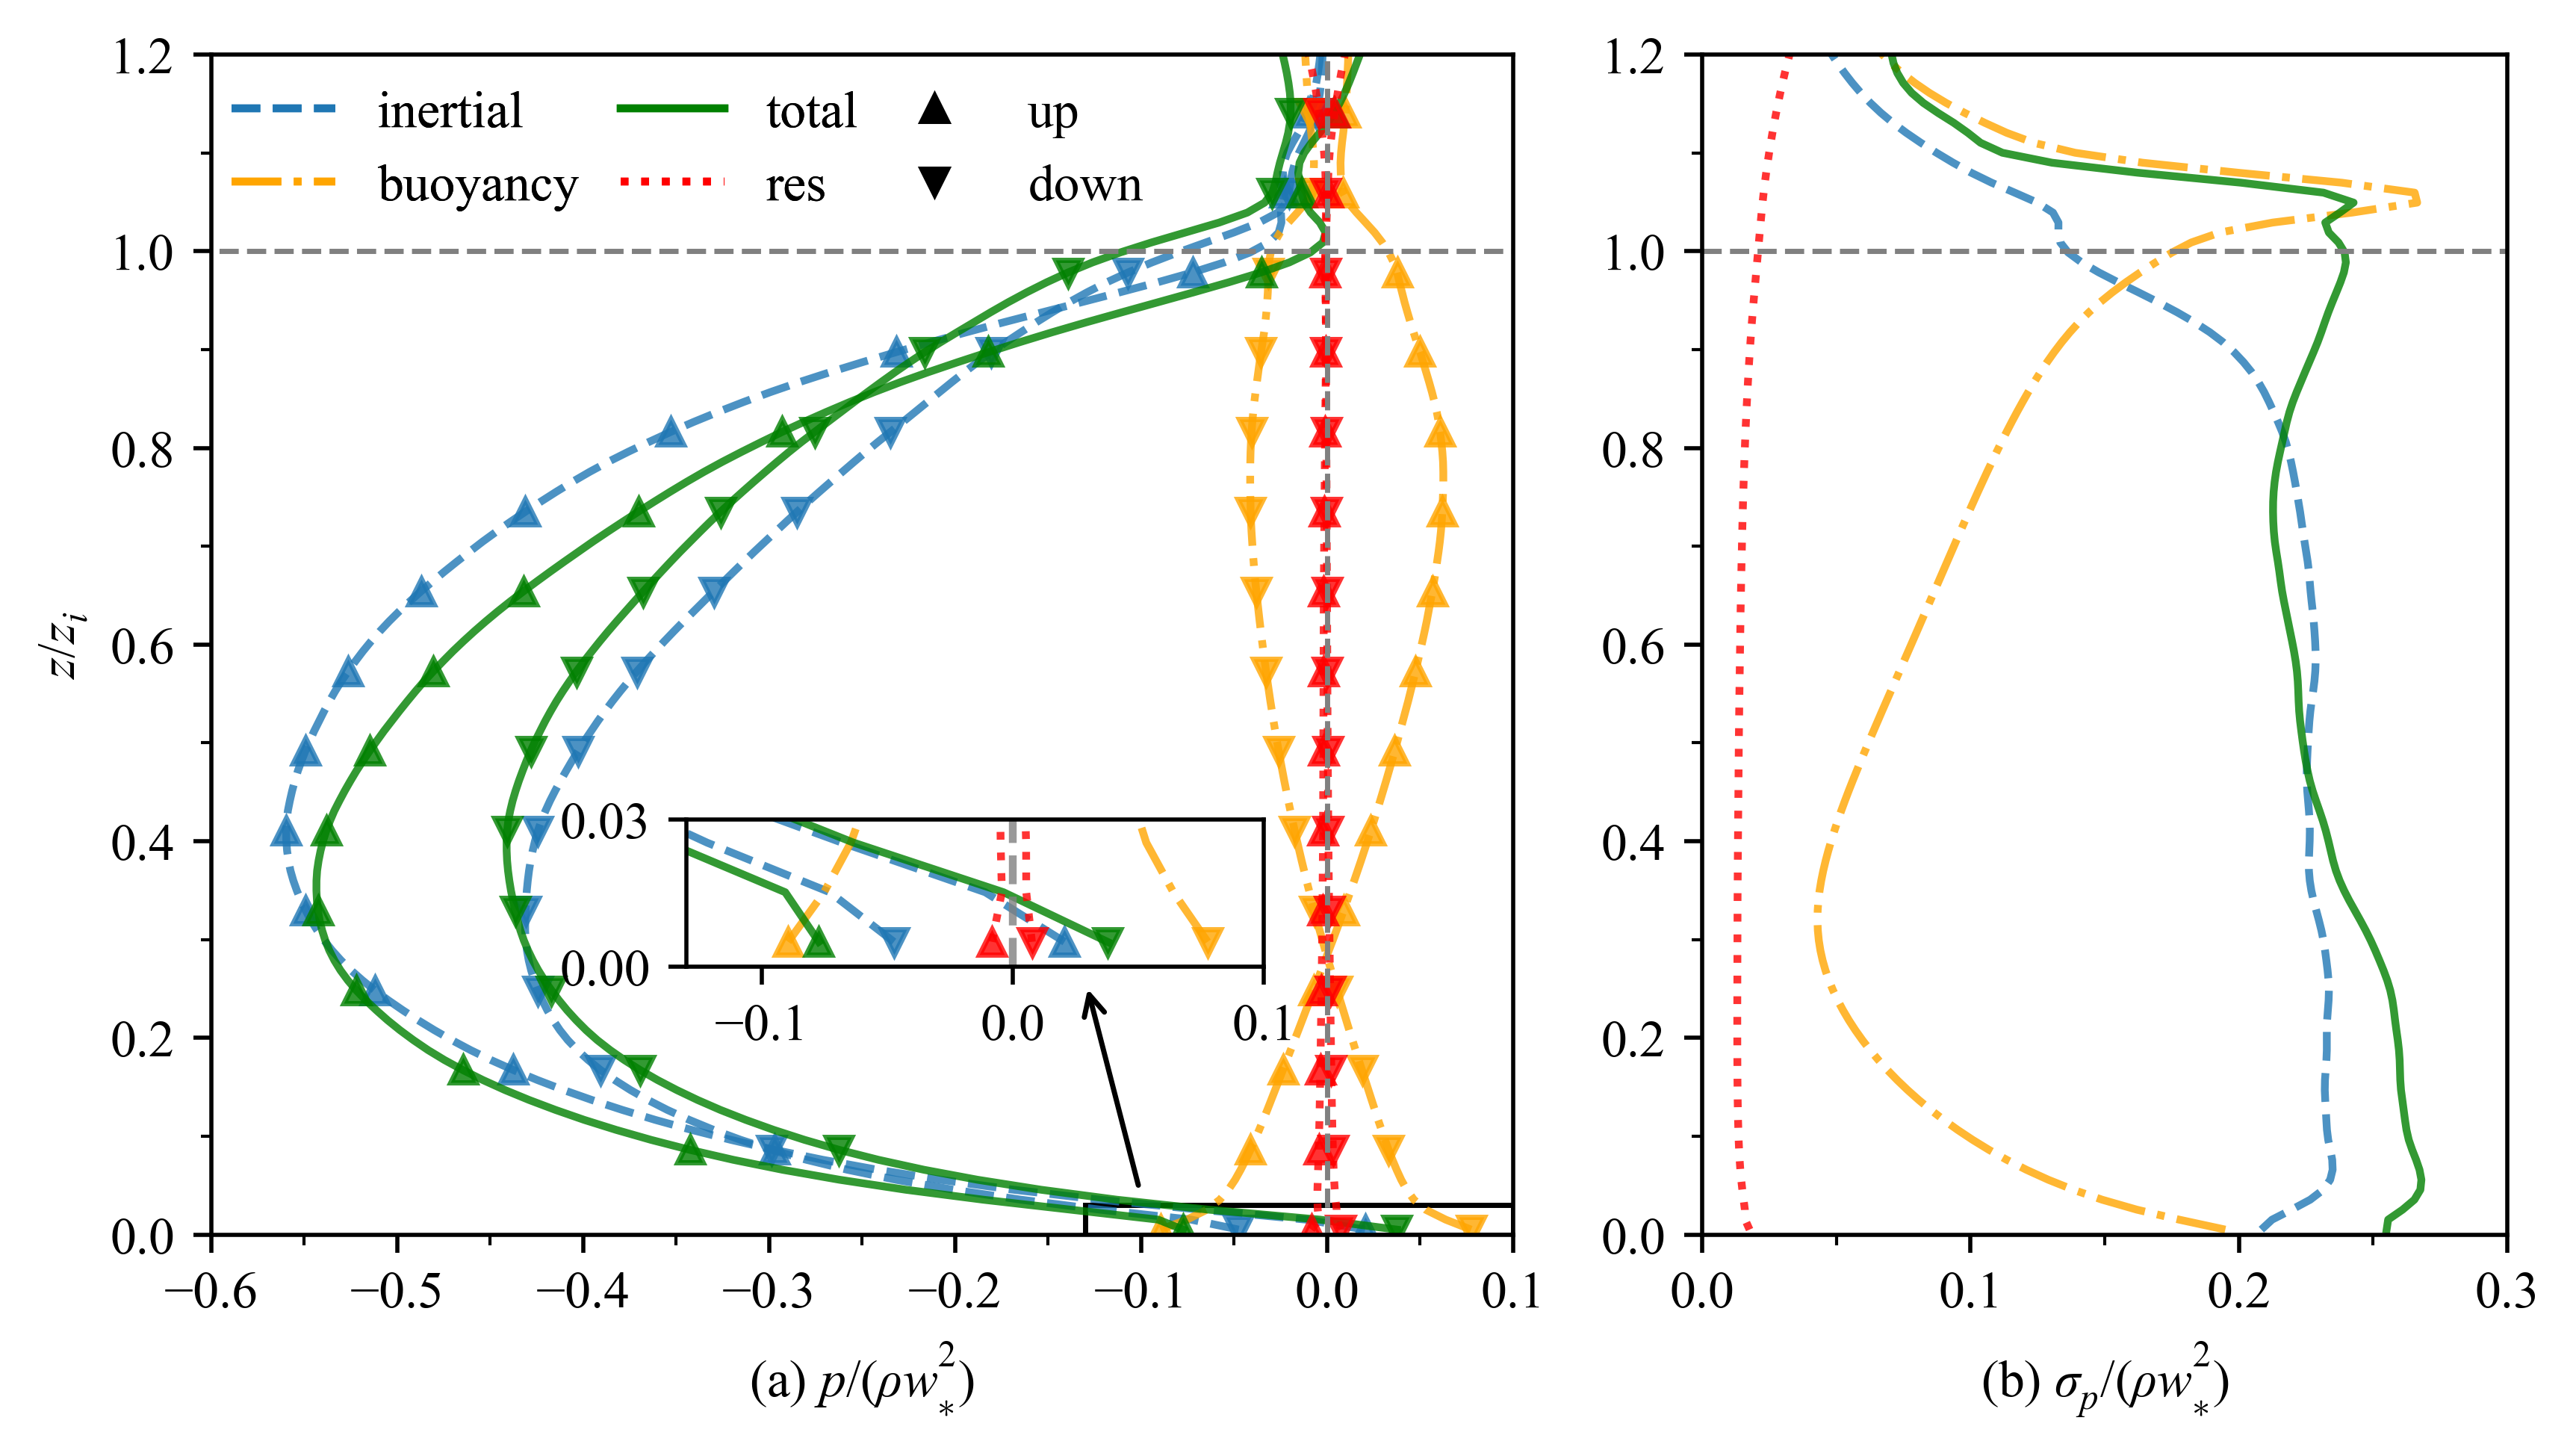

In [28]:
from matplotlib import gridspec

# 绘图
fig = plt.figure(figsize=(7, 4), dpi=500) 
gs = gridspec.GridSpec(1, 5)  # 2行2列，左边宽度是右边的两倍

######################### 绘制(a)图 ##########################

ax1 = fig.add_subplot(gs[0, :3])  # ":" 表示所有行，"0" 表示第1列
mean_up_res = mean_up['p'] - mean_up['p_inertial'] - mean_up['p_buoyancy']
mean_down_res = mean_down['p'] - mean_down['p_inertial'] - mean_down['p_buoyancy']

ax1.plot(mean_up['p_inertial'], z_coords/zi, '--^', alpha=0.8, color=cfg.colors[0], markersize=5, markevery=8)
ax1.plot(mean_down['p_inertial'], z_coords/zi, '--v', color=cfg.colors[0], alpha=0.8, markersize=5, markevery=8)
ax1.plot(mean_up['p_buoyancy'], z_coords/zi, '-.^', alpha=0.8, color=cfg.colors[1], markersize=5, markevery=8)
ax1.plot(mean_down['p_buoyancy'], z_coords/zi, '-.v', color=cfg.colors[1], alpha=0.8, markersize=5, markevery=8)
ax1.plot(mean_up['p'], z_coords/zi, '-^', color=cfg.colors[2], alpha=0.8, markersize=5, markevery=8)
ax1.plot(mean_down['p'], z_coords/zi, '-v', color=cfg.colors[2], alpha=0.8, markersize=5, markevery=8)
ax1.plot(mean_up['res'], z_coords/zi, ':^', color=cfg.colors[3], alpha=0.8, markersize=5, markevery=8)
ax1.plot(mean_down['res'], z_coords/zi, ':v', color=cfg.colors[3], alpha=0.8, markersize=5, markevery=8)

# 添加自定义图例，解释 marker
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], marker='^', color='k', linestyle='None', markersize=5, label='up'),
                Line2D([0], [0], marker='v', color='k', linestyle='None', markersize=5, label='down')]
legend1 = ax1.legend(handles=custom_lines, loc=[0.5, 0.85], frameon=False)
legend1.get_title().set_ha('left')  # 让title靠左
ax1.add_artist(legend1)

custom_lines = [Line2D([0], [0], color=cfg.colors[0], linestyle='--', label='inertial'),
                Line2D([0], [0], color=cfg.colors[1], linestyle='-.', label='buoyancy'),
                Line2D([0], [0], color=cfg.colors[2], linestyle='-', label='total'),
                Line2D([0], [0], color=cfg.colors[3], linestyle=':', label='res'),]
legend2 = ax1.legend(handles=custom_lines, loc=[0, 0.85], frameon=False, ncol=2, columnspacing=0.8)
legend2.get_title().set_ha('left')  # 让title靠左
ax1.add_artist(legend2)

ax1.minorticks_on()
ax1.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax1.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(AutoMinorLocator(2)) # Includes the major tick
ax1.yaxis.set_minor_locator(AutoMinorLocator(2)) # Includes the major tick

ax1.hlines(1, -1.5, 0.3, color='grey', ls='dashed', lw=1)
ax1.axvline(x=0, ymin=0, ymax=1.2, c="grey", ls='dashed', lw=1)

ax1.set_ylim(0.0, 1.2)
ax1.set_yticks(np.arange(0.0, 1.21, 0.2))
ax1.set_xlim(-0.6, 0.1)
ax1.set_xticks([-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1])
ax1.set_ylabel('$z/z_i$')
ax1.set_xlabel('(a) $p/(\\rho w^2_{\\ast})$')

########################## 绘制(b)图 ##########################
ax2 = fig.add_subplot(gs[0, -2:])

ax2.plot(std['p_inertial'], z_coords/zi, '--', alpha=0.8, color=cfg.colors[0], markersize=5, markevery=8)
ax2.plot(std['p_buoyancy'], z_coords/zi, '-.', alpha=0.8, color=cfg.colors[1], markersize=5, markevery=8)
ax2.plot(std['p'], z_coords/zi, '-', color=cfg.colors[2], alpha=0.8, markersize=5, markevery=8)
ax2.plot(std['res'], z_coords/zi, ':', color=cfg.colors[3], alpha=0.8, markersize=5, markevery=8)

ax2.hlines(1, 0, 0.7, color='grey', ls='dashed', lw=1)

ax2.minorticks_on()
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax2.yaxis.set_major_locator(plt.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(AutoMinorLocator(2)) # Includes the major tick
ax2.yaxis.set_minor_locator(AutoMinorLocator(2)) # Includes the major tick

ax2.set_xlim(0, 0.3)
ax2.set_xticks([0, 0.1, 0.2, 0.3])
ax2.set_ylim(0.0, 1.2)
ax2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])

ax2.set_xlabel('(b) $\sigma_p/(\\rho w^2_{\\ast})$')

########################## 绘制 底部放大 图 ##########################
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins_bot = inset_axes(ax1, width="85%", height="20%", bbox_to_anchor=(-0.34, -0.35, 1, 1.5), bbox_transform=ax.transAxes)
axins_bot.set_ylim(0, 0.03)
axins_bot.set_yticks([0, 0.03])
axins_bot.set_xlim(-0.13, 0.1)
for line in ax1.get_lines():
    axins_bot.plot(line.get_xdata(), line.get_ydata(), linestyle=line.get_linestyle(),
                   color=line.get_color(), marker=line.get_marker(), alpha=0.8, markersize=5, markevery=8)

import matplotlib.patches as patches
rect = patches.Rectangle((-0.13, 0), 0.23, 0.03, edgecolor='k', facecolor='none')
ax1.add_patch(rect)
ax1.annotate('', xy=(-0.13, 0.26), xytext=(-0.1, 0.04), arrowprops=dict(arrowstyle="->", color='k'))

plt.tight_layout()
plt.show()